In [42]:
import pandas as pd
import numpy as np
import random

### Create data randomly

In [365]:
np.random.seed(2)
ID = pd.DataFrame(np.random.randint(1, 80000, 1000000), columns=['ID'])
ID.head(3)

,ID
0,72174
1,44567
2,31020


In [366]:
np.random.seed(2)
Date = pd.DataFrame(pd.to_datetime(np.random.randint(15000, 18700, 1000000), unit='D'), columns=['BuyDate'])
Date.head(3)

,BuyDate
0,2019-12-10
1,2018-02-13
2,2018-01-10


In [367]:
print(Date['BuyDate'].max())
print(Date['BuyDate'].min())
print(Date['BuyDate'].mean())
print(Date['BuyDate'].mode())

2021-03-13 00:00:00
2011-01-26 00:00:00
2016-02-18 06:57:32.976000512
0   2016-11-19
dtype: datetime64[ns]


In [368]:
np.random.seed(2)
Amount = pd.DataFrame((np.random.rand(1000000,1)*1000).round(2), columns=['BuyAmount'])
Amount.head(3)

,BuyAmount
0,435.99
1,25.93
2,549.66


In [371]:
Amount.describe()

,BuyAmount
count,1000000.000000
mean,499.468518
std,289.132797
min,0.000000
25%,248.590000
50%,499.490000
75%,749.810000
max,1000.000000


### Combine random data to create _Customer_ dataset for analysis

In [372]:
Customer = pd.DataFrame(columns=['ID', 'BuyDate', 'BuyAmount'])

Customer['ID'] = ID['ID']
Customer['BuyDate'] = Date['BuyDate']
Customer['BuyAmount'] = Amount['BuyAmount']
Customer

,ID,BuyDate,BuyAmount
0,72174,2019-12-10,435.99
1,44567,2018-02-13,25.93
2,31020,2018-01-10,549.66
3,33868,2015-06-22,435.32
4,44296,2020-12-10,420.37
...,...,...,...
999995,26343,2020-05-10,449.92
999996,41994,2017-09-11,663.12
999997,47806,2015-09-21,784.83
999998,65148,2018-12-17,7.78


In [373]:
Customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   ID         1000000 non-null  int32         
 1   BuyDate    1000000 non-null  datetime64[ns]
 2   BuyAmount  1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 19.1 MB


In [374]:
# Check if there are Null
for col in Customer.columns:
    print(Customer[Customer[col].isna() == True])

Empty DataFrame
Columns: [ID, BuyDate, BuyAmount]
Index: []
Empty DataFrame
Columns: [ID, BuyDate, BuyAmount]
Index: []
Empty DataFrame
Columns: [ID, BuyDate, BuyAmount]
Index: []


In [375]:
# Drop duplicates
Customer = Customer.drop_duplicates()

In [376]:
Customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   ID         1000000 non-null  int32         
 1   BuyDate    1000000 non-null  datetime64[ns]
 2   BuyAmount  1000000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int32(1)
memory usage: 26.7 MB


### Choose the period between 2018 and 2020 for analysis

In [386]:
Customer1820 = Customer[Customer['BuyDate'].between('20180101', '20201231') ]
Customer1820

,ID,BuyDate,BuyAmount
0,72174,2019-12-10,435.99
1,44567,2018-02-13,25.93
2,31020,2018-01-10,549.66
4,44296,2020-12-10,420.37
9,70704,2020-03-14,266.83
...,...,...,...
999991,255,2018-05-28,944.02
999993,11937,2020-02-03,220.30
999994,79499,2020-08-02,262.39
999995,26343,2020-05-10,449.92


### Create _FRM_ Dataset with Frequency, Recency and Monetary

In [387]:
FRM = pd.DataFrame(columns=['ID', 'Frequency', 'Recency', 'Monetary'])
FRM

,ID,Frequency,Recency,Monetary


In [389]:
RFM_R = Customer1820[['ID', 'BuyDate']].groupby(['ID']).max().rename(columns={'BuyDate':'Recency'})

RFM_F = Customer1820[['ID', 'BuyDate']].groupby(['ID']).count().rename(columns={'BuyDate':'Frequency'})

RFM_M = Customer1820[['ID', 'BuyAmount']].groupby(['ID']).sum().rename(columns={'BuyAmount':'Monetary'})

RFM = RFM_R.merge(RFM_F, how='outer', on='ID').merge(RFM_M, how='outer', on='ID')

RFM.head(3)

,Recency,Frequency,Monetary
ID,,,
1,2020-08-11,2,1677.59
2,2020-03-22,3,1913.60
3,2020-04-19,4,2834.10


In [396]:
RFM.describe()

,Frequency,Monetary
count,78047.000000,78047.000000
mean,3.787679,1893.212214
std,1.837436,1078.125426
min,1.000000,0.030000
25%,2.000000,1074.610000
50%,4.000000,1756.290000
75%,5.000000,2554.965000
max,13.000000,8166.990000


In [398]:
# Set up 4 segments for R, F, M
RFM['Rflag'] = pd.qcut(RFM['Recency'], 4, labels=[1,2,3,4])
RFM['Fflag'] = pd.qcut(RFM['Frequency'], 4, labels=[1,2,3,4])
RFM['Mflag'] = pd.qcut(RFM['Monetary'], 4, labels=[1,2,3,4])
RFM['Score'] = RFM['Rflag'].astype('str') + RFM['Fflag'].astype('str') + RFM['Mflag'].astype('str')
RFM

,Recency,Frequency,Monetary,Rflag,Fflag,Mflag,Score
ID,,,,,,,
1,2020-08-11,2,1677.59,3,1,2,312
2,2020-03-22,3,1913.60,2,2,3,223
3,2020-04-19,4,2834.10,2,2,4,224
4,2019-04-28,1,953.29,1,1,1,111
5,2020-12-08,2,564.63,4,1,1,411
...,...,...,...,...,...,...,...
79995,2020-09-19,2,923.78,3,1,1,311
79996,2019-07-09,2,411.92,1,1,1,111
79997,2018-03-15,1,83.88,1,1,1,111


In [400]:
RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78047 entries, 1 to 79999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Recency    78047 non-null  datetime64[ns]
 1   Frequency  78047 non-null  int64         
 2   Monetary   78047 non-null  float64       
 3   Rflag      78047 non-null  category      
 4   Fflag      78047 non-null  category      
 5   Mflag      78047 non-null  category      
 6   Score      78047 non-null  object        
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [401]:
RFM[RFM['Score'] == '444']

,Recency,Frequency,Monetary,Rflag,Fflag,Mflag,Score
ID,,,,,,,
15,2020-11-12,7,4235.38,4,4,4,444
49,2020-10-28,6,3221.68,4,4,4,444
62,2020-12-04,8,5024.12,4,4,4,444
68,2020-12-23,7,4939.52,4,4,4,444
81,2020-11-08,7,3125.67,4,4,4,444
...,...,...,...,...,...,...,...
79896,2020-12-28,7,2985.97,4,4,4,444
79924,2020-11-07,7,4373.42,4,4,4,444
79926,2020-12-08,7,4600.87,4,4,4,444


In [402]:
RFM['Score'].describe()

count     78047
unique       60
top         111
freq       8023
Name: Score, dtype: object

### Get Score from RFM analysis

In [404]:
RFM_Score = RFM[['Score', 'Recency']].groupby('Score').count().rename(columns={'Recency':'Count'})
RFM_Score.tail(5)

,Count
Score,
434,1681
441,8
442,113
443,808
444,4571


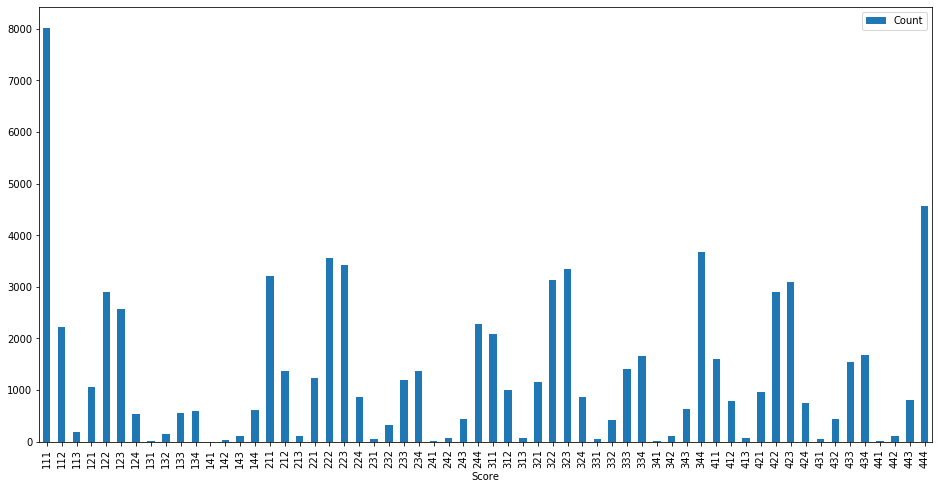

In [364]:
RFM_Score.plot.bar(figsize=(16,8))